# 3. Models for global demand: time series forecasting

**Time series forecasting** help to predict the future values of demand based on previous known values, it is used when the dependend variable varies over time

There are 4 main components that define a Time series:
1. Trend: upward and downward movement of the demand over a period of time
2. Seasonality: seasonal variances of the data
3. Residuals: noise - random variations
4. Cyclicity: the behavior is repeated after an interval of time

## 3.1. Analyzing the time series

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Import the data we created in the first notebook
rides_per_hour = pd.read_csv('movements_grouped.csv')

In [5]:
rides_per_hour = rides_per_hour[['datetime', 'date', 'weekday', 'hour',  'time', 'month', 'is_holiday_x', 'rides', 'year', 'is_weekend']]

In [6]:
rides_per_hour.set_index('datetime', inplace=True)
rides_per_hour.sort_index(inplace=True)

In [7]:
rides_per_hour['weekday'] = rides_per_hour['weekday'].astype('category')

### Decomposition of the time series

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(rides_per_hour['rides'], model='additive', freq=24)

<ipython-input-8-7163e3b2da98>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(rides_per_hour['rides'], model='additive', freq=24)


### Adding lag values we will use for the model

We are going to use the lag values of the variable rides as predictors in our machine learning models, and also we are going to use them for our naive model. We are going to consider the following lags:

- rides lag 7: 7 days before at the same hour
- rides lag 1: 1 day before at the same hour
- rides lag 2: 2 days before at the same hour
- rides lag 1 month: 1 month before at the same hour
- rides lag 12 hours

In [9]:
rides_per_hour['rides_lag_7'] = rides_per_hour['rides'].shift(7*24)
rides_per_hour['rides_lag_1'] = rides_per_hour['rides'].shift(1*24)
rides_per_hour['rides_lag_2'] = rides_per_hour['rides'].shift(2*24)
rides_per_hour['rides_lag_1_month'] = rides_per_hour['rides'].shift(30*24)
rides_per_hour['rides_lag_12_hours'] = rides_per_hour['rides'].shift(12)

In [10]:
rides_per_hour

,date,weekday,hour,time,month,is_holiday_x,rides,year,is_weekend,rides_lag_7,rides_lag_1,rides_lag_2,rides_lag_1_month,rides_lag_12_hours
datetime,,,,,,,,,,,,,,
2018-12-31 23:00:00,2018-12-31,Monday,23,23:00:00,12,0,176,2018,0,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:00:00,2019-01-01,Tuesday,0,00:00:00,1,1,254,2019,0,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,2019-01-01,Tuesday,1,01:00:00,1,1,169,2019,0,NaN,NaN,NaN,NaN,NaN
2019-01-01 02:00:00,2019-01-01,Tuesday,2,02:00:00,1,1,105,2019,0,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00,2019-01-01,Tuesday,3,03:00:00,1,1,83,2019,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30 19:00:00,2021-06-30,Wednesday,19,19:00:00,6,0,813,2021,0,814.0,749.0,691.0,610.0,815.0
2021-06-30 20:00:00,2021-06-30,Wednesday,20,20:00:00,6,0,552,2021,0,559.0,581.0,507.0,224.0,565.0
2021-06-30 21:00:00,2021-06-30,Wednesday,21,21:00:00,6,0,571,2021,0,615.0,482.0,400.0,205.0,509.0


###### Let's analyze the correlation between our variables

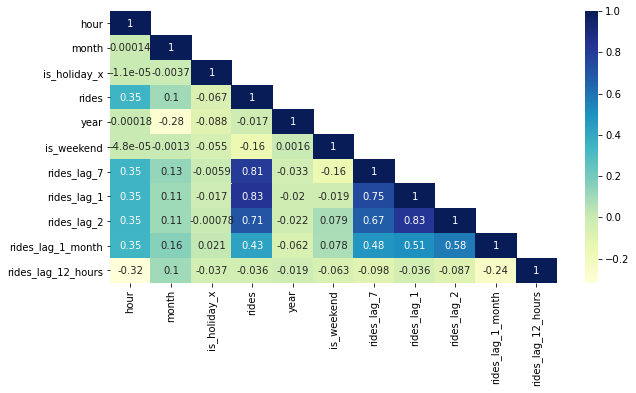

In [11]:
corr_matrix = rides_per_hour.corr()
fig = plt.figure(figsize=(10, 5))

mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False

sns.heatmap(corr_matrix, mask = mask, annot=True, cbar=True,cmap="YlGnBu")
plt.show()

From the correlation matrix we can see that the variable rides we want to predict is highly correlated with.
- rides_lag_7 (demand 7 days before at the same time): coefficient 0.81
- rides_lag_1 (demand 1 day before at the same hour): coefficient 0.83
- rides_lag_2 (demand 2 days before at the same hour): coefficient 0.71

The variable rides is also correlated with:
- rides_lag_1_month (demand one month before at the same hour): coefficient 0.43
- hour: coefficient 0.35

##### Check if the data is stationary

In [12]:
from statsmodels.tsa.stattools import adfuller

To check if the data is stationary we are going to perform the **Dickey-Fuller test**: This test is used to try the null hypotesis: time-series data is non-stationary. It calculates the p-value and compareit with a threshold value of 0.05. If the p-value is lower than this level, data is stationary

In [13]:
df_test=adfuller(rides_per_hour['rides'], autolag='AIC', regression = 'ct')
df_test_results = pd.Series(df_test[0:4], index = ['Test statistic', 'p-value', 'Number of lags', 'Number observations'])
for key,value in df_test[4].items():
    df_test_results['Critical value (%s)' %key]=value

In [14]:
#Results of Dickey-Fuller test
df_test_results

Test statistic         -8.521028e+00
p-value                 4.488707e-12
Number of lags          4.700000e+01
Number observations     2.184100e+04
Critical value (1%)    -3.959185e+00
Critical value (5%)    -3.410691e+00
Critical value (10%)   -3.127168e+00
dtype: float64

Conclusions: we reject the null hypotesis and conclude that our **time series is stationary**

## 3.2. Naive model

We are going to create a naive model that will serve us as a baseline to compare it with the models we are going to build. 

We have just seen that the variable rides is highly correlated with the variable rides_lag_7, which is the demand of bikes at the same hour the week before, so for our naive model we are going to consider that the demand is the same as rides_lag_7

In [15]:
rides_naive=rides_per_hour.dropna(subset=['rides_lag_7'])

In [16]:
rides_naive.columns

Index(['date', 'weekday', 'hour', 'time', 'month', 'is_holiday_x', 'rides',
       'year', 'is_weekend', 'rides_lag_7', 'rides_lag_1', 'rides_lag_2',
       'rides_lag_1_month', 'rides_lag_12_hours'],
      dtype='object')

In [17]:
train_end = int(0.95*len(rides_naive))

In [18]:
train = rides_naive[:train_end]
test = rides_naive[train_end:]

In [19]:
X_train, y_train = train['rides_lag_7'], train['rides']
X_test, y_test = test['rides_lag_7'], test['rides']

In [20]:
predictions = X_test
demand = y_test

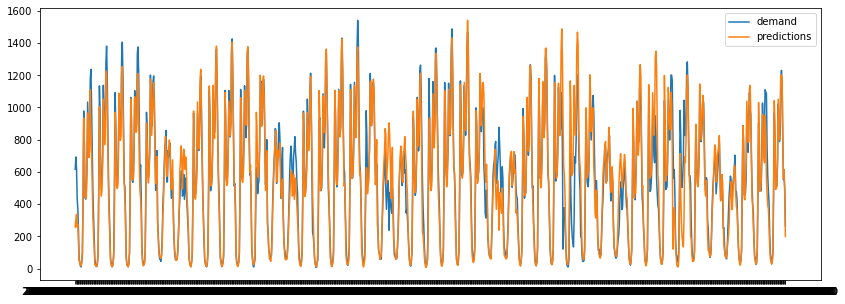

In [21]:
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

###### Evaluating model

We are going to create a dataframe where we are going to add the results of all the models we are going to try. In this dataframe we are going to add the metrics:

- MSE
- MAE
- RMSE
- R2

In [22]:
from sklearn import metrics
def calculate_metrics(forecast,demand):
    mse = metrics.mean_squared_error(forecast,demand)
    mae = metrics.mean_absolute_error(forecast,demand)
    rmse = np.sqrt(metrics.mean_squared_error(forecast,demand))
    r2 = metrics.r2_score(forecast,demand)
    return mse, mae, rmse, r2

In [23]:
evaluation_models = pd.DataFrame(columns=["model", "MSE", "MAE", "RMSE", "R2"])

In [24]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'naive', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)


In [25]:
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,15194.942042,71.676173,123.267766,0.890989


## 3.3. Machine Learning Models

Advantages of using Machine learning methods for forecasting.
* Ease of including exogenous variables in addition to autoregressive variables
* Allows the incorporation of non-linear behaviors
* High scalability, useful when large amount of data is available

There are also some disadvantages for this:

* Restructuring the data to fit a regression problem
* Iterative processes are needed, each prediction uses the previous predictions
* Validation requires specific strategies. Traditional cross validation does not work

The forecast in a time series can be decomposed in two parts:
    
    Forecast = patterns (explained variance) + unexplained variance
    
* Patterns: it has a repetitive character over time (trend, seasonality, cyclical values)
* Unexplained variance: influences the target variable but cannot be explained by the past

The higher the importance of the patterns, the higher the probability of creating autorregresive forecasting models. The higher the importance of the unexplained variance requires to incorporate additional variables to the model, to help to understand the observed values

It's importat to control the bias and variance of the model. Small trees (few braches) have low variance but fail to represent well the relationship between variables (high bias). On the other hand, large trees are very close to the training data, so they will propably have high variance. We need to control the balance between bias and variance this can be solved with ensemble methods.

Ensemble methods combine multiple models in a new one, with the aim of balancing bias and variance. Typeas of ensembling methods:

1. Bagging: multiple models are fitted, each with a different subset of the training data. As a final value, the mean of all predictions is taken. Random Forest belong to this category
2. Boosting: multiple simple models are adjusted sequentially, so each model learns from the errors of the previous one. Finally, the mean of all predictions is taken. Gradient Boosting belong to this category

We need to transform the temporal series in a matrix, where each value is related to the precedent lags

#### 3.3.1. Random Forest Ensemble

Random Forest is a non parametric method, so no specific distribution is required. Also, this type of models require less data cleaning and preprocessing compared to other statistical methods, this models do not require standarization.
They are not greatly influenced by outliers.

First we need to prepare the data for the model. 

To take into account the day of the week we are going to perform a One-hot encoding, this process takes categorical variables and converts it to numerical representation without an arbitrary ordering.

We are going to perform the One Hot Encoding for the columns:

- Weekday
- Month
- Hour

This way the model is giving the same importances to all the variables

In [26]:
rides_per_hour = pd.get_dummies(rides_per_hour, columns=['weekday', 'hour', 'month'])

In [27]:
rides_per_hour.columns

Index(['date', 'time', 'is_holiday_x', 'rides', 'year', 'is_weekend',
       'rides_lag_7', 'rides_lag_1', 'rides_lag_2', 'rides_lag_1_month',
       'rides_lag_12_hours', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12'],
      dtype='object')

In [28]:
#We save the columns we are using as predictors in columns for model and the target we want to predict in target
columns_for_model = [column for column in rides_per_hour.columns
                      if column.startswith(('weekday', 'hour', 'month'))]

columns_for_model.extend(['is_holiday_x', 'is_weekend', 'rides_lag_7', 'rides_lag_1'])

target = 'rides'

In [29]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor


In [30]:
rides_per_hour_models = rides_per_hour.dropna(subset = ['rides_lag_7'])

In [31]:
rides_per_hour_models

,date,time,is_holiday_x,rides,year,is_weekend,rides_lag_7,rides_lag_1,rides_lag_2,rides_lag_1_month,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-07 23:00:00,2019-01-07,23:00:00,1,132,2019,0,176.0,202.0,218.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2019-01-08 00:00:00,2019-01-08,00:00:00,0,64,2019,0,254.0,160.0,238.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2019-01-08 01:00:00,2019-01-08,01:00:00,0,38,2019,0,169.0,88.0,164.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2019-01-08 02:00:00,2019-01-08,02:00:00,0,21,2019,0,105.0,66.0,107.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2019-01-08 03:00:00,2019-01-08,03:00:00,0,25,2019,0,83.0,63.0,72.0,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30 19:00:00,2021-06-30,19:00:00,0,813,2021,0,814.0,749.0,691.0,610.0,...,0,0,0,1,0,0,0,0,0,0
2021-06-30 20:00:00,2021-06-30,20:00:00,0,552,2021,0,559.0,581.0,507.0,224.0,...,0,0,0,1,0,0,0,0,0,0
2021-06-30 21:00:00,2021-06-30,21:00:00,0,571,2021,0,615.0,482.0,400.0,205.0,...,0,0,0,1,0,0,0,0,0,0


In [32]:
rides_per_hour_models['rides_lag_7'] = rides_per_hour_models['rides_lag_7'].astype(int)
rides_per_hour_models['rides_lag_1'] = rides_per_hour_models['rides_lag_1'].astype(int)

<ipython-input-32-5f85883a00da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_per_hour_models['rides_lag_7'] = rides_per_hour_models['rides_lag_7'].astype(int)
<ipython-input-32-5f85883a00da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_per_hour_models['rides_lag_1'] = rides_per_hour_models['rides_lag_1'].astype(int)


In [39]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [45]:
#Verification that the temporal series is complete
(rides_per_hour.index==pd.date_range(start = rides_per_hour.index.min(),
                                   end = rides_per_hour.index.max(),
                                   freq='1H')
).all()

True

In [33]:
#Division of the dataset in train and test
train_end = int(0.95*len(rides_per_hour_models))
train = rides_per_hour_models[:train_end]
test = rides_per_hour_models[train_end:]

In [34]:
X_train, y_train = train[columns_for_model], train[target]
X_test, y_test = test[columns_for_model], test[target]

A ForecasterAutoreg is created and trained from a RandomForestRegressor and a time window of 24*7 lags, using the past 7 days demand as predictors

In [46]:
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),
                              lags = 24*7)

forecaster.fit(y_train)
forecaster

C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
Window size: 168 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 20633] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': T

In [57]:
#Prediction of test
predictions = forecaster.predict(steps=len(X_test))
predictions = predictions.reset_index()
predictions = predictions['pred']
predictions

0       682.83
1       623.16
2       511.90
3       404.77
4       416.84
         ...  
1082    650.65
1083    485.70
1084    395.93
1085    358.65
1086    210.59
Name: pred, Length: 1087, dtype: float64

In [53]:
demand = y_test
demand = demand.reset_index()
demand = demand['rides']

In [54]:
demand

0       617
1       693
2       623
3       435
4       373
       ... 
1082    813
1083    552
1084    571
1085    499
1086    264
Name: rides, Length: 1087, dtype: int64

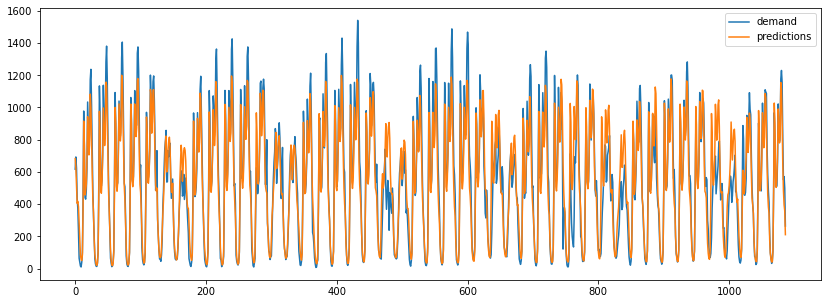

In [58]:
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

In [59]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'ForecastAutoreg', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)


In [60]:
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,15194.942042,71.676173,123.267766,0.890989
1,ForecastAutoreg,17340.703408,87.766559,131.684105,0.842387


### Hyperparameters

We are going to search for the best hyperparameters for the model and the number of lags required, for this we are going to perform a grid search

In [ ]:
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),
                              lags =24*7)

#Lags used as predictors
possible_lags = [24*7]

#hyperparameters of regressor
param_grid = {'n_estimators':[100,500],
             'max_depth': [3,5,10]}

grid_results = grid_search_forecaster(forecaster = forecaster,
                                     y = y_train,
                                     param_grid = param_grid,
                                     lags_grid = possible_lags,
                                     steps = 24,
                                     refit = True,
                                     metric = 'mean_squared_error',
                                     initial_train_size=int(len(X_train)*0.5),
                                      fixed_train_size = False,
                                      return_best=True,
                                      verbose=False
                                     )

loop param_grid:   0%|                                              | 0/6 [00:00<?, ?it/s]

Number of models compared: 6
Forecaster will be fit 430 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\sk

C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\sk

C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\sk

C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\sk

C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\sk

C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\sk

C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\sk

C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\paula\Anaconda3\lib\site-packages\sk

Best results are the ones that use a lag and the hyperparameters:
* max_depth: 
* n_estimators:

##### Final model

In [ ]:
regressor = RandomForestRegressor(max_depth=,n_estimators =, random_state=123)
forecaster = ForecasterAutoreg(regressor=regressor,
                              lags=24*7)
predictions = forecaster.predicts(steps=len(X_test))

#### 3.3.2. Gradient Boosting: LGBMRegressor

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
forecaster = ForecasterAutoreg(regressor = LGBMRegressor(max_depth=2, learning_rate=0.1, n_estimators=50),
                              lags=[24,24*7])
forecaster

In [ ]:
forecaster.fit(y=X_train, 'rides')
forecast = forecaster.predict(steps=len(X_train))

##### Backtesting

In [ ]:
metric, predictions = backtesting_forecaster(forecaster = forecaster
                                            y = rides_per_hour_model['rides'],
                                            initial_train_size=len(X_train),
                                            steps = len(X_test),
                                            metric = 'mean_absolute_error',
                                            refit=False,
                                            verbose=True)

In [ ]:
metric

### Hyperparameters

In [ ]:
param_grid = {
    'max_iter': [100,500]
    'max_depth':[3,10]
    'learning_rate':[0.01,0.1]
}

possible_lags = [24*7, 24]


results_grid = grid_search_forecaster(forecaster = forecaster,
                                     y = X_train,
                                     param_grid = param_grid,
                                     lags_grid = possible_lags,
                                     steps=len(X_test),
                                     refit=False,
                                     metric = 'mean_absolute_error',
                                     initial_train_size=int(len(X_train)),
                                     return_best=True,
                                     verbose=False)

In [ ]:
results_grid.head(10)

In [ ]:
#Backtest with best hyperparameters
metric, predictions = backtesting_forecaster(forecaster = forecaster
                                            y = rides_per_hour_model['rides'],
                                            initial_train_size=len(X_train),
                                            steps = len(X_test),
                                            metric = 'mean_absolute_error',
                                            refit=False,
                                            verbose=True)

In [ ]:
metric

#### Adding exogenous variables: weekday and is_holiday

We saved our exogenous variables in a variable called columns_for_model

In [ ]:
columns_for_model

In [ ]:
forecaster = ForecasterAutoreg(regressor = LGBMRegressor(max_depth=2, learning_rate=0.1, n_estimators=50),
                              lags=[24,24*7])
forecaster.fit(y = X_test,
              exog = X_test[])